# Introduction: Home Credit Default Risk Competition

The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)


# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need.

    There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file. <br>

We will stick to using only the main application training and testing data. If we have a time we will use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. <br>
## Metric: ROC AUC

Once we have a grasp of the data (reading through the [column descriptions](https://www.kaggle.com/c/home-credit-default-risk/data) helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model. 

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1.

## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot

sns.set_palette("tab10")


# 1. Obtaining Data
 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [3]:
# List files available
print(os.listdir("../input/"))

['sample_submission.csv', 'bureau_balance.csv', 'POS_CASH_balance.csv', 'application_train.csv', 'HomeCredit_columns_description.csv', 'application_test.csv', 'previous_application.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'bureau.csv']


In [4]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
#                         ,true_values=['Yes','Y'], false_values=['No','N']
                       
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [5]:
# Testing data features
app_test = pd.read_csv('../input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Cleaning Data

## Information About Features
    Length of Dataframe, Data type, and Null values

In [6]:
app_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 543.7 MB


In [7]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
app_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

We can optimize the memory usage by use Boolean and Category datatypes

In [9]:
def extract_cols_contain(df:pd.DataFrame,pattern:str)-> list:
    """
        return list of columns start with the specified word.
    Parameters:
    -----------------------------------
        df: pandas.DataFrame
            dataFrame to be checked
        pattern: str
            pattern to search for.
    Return:
    -----------------------------------
        list of the desired columns.
         
    """
    return [col for col in df if pattern in col]

In [10]:
reg_city_cols = extract_cols_contain(app_train,'_NOT_')
reg_city_cols

['REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

In [11]:
flag_cols = extract_cols_contain(app_train,'FLAG')
flag_cols

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [12]:
bool_cols = reg_city_cols + flag_cols
bool_cols[:7]

['REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_OWN_CAR']

## Check True and False Values in the Boolean columns

In [13]:
[(col,app_train[col].unique()) for col in bool_cols]

[('REG_REGION_NOT_LIVE_REGION', array([0, 1])),
 ('REG_REGION_NOT_WORK_REGION', array([0, 1])),
 ('LIVE_REGION_NOT_WORK_REGION', array([0, 1])),
 ('REG_CITY_NOT_LIVE_CITY', array([0, 1])),
 ('REG_CITY_NOT_WORK_CITY', array([0, 1])),
 ('LIVE_CITY_NOT_WORK_CITY', array([0, 1])),
 ('FLAG_OWN_CAR', array(['N', 'Y'], dtype=object)),
 ('FLAG_OWN_REALTY', array(['Y', 'N'], dtype=object)),
 ('FLAG_MOBIL', array([1, 0])),
 ('FLAG_EMP_PHONE', array([1, 0])),
 ('FLAG_WORK_PHONE', array([0, 1])),
 ('FLAG_CONT_MOBILE', array([1, 0])),
 ('FLAG_PHONE', array([1, 0])),
 ('FLAG_EMAIL', array([0, 1])),
 ('FLAG_DOCUMENT_2', array([0, 1])),
 ('FLAG_DOCUMENT_3', array([1, 0])),
 ('FLAG_DOCUMENT_4', array([0, 1])),
 ('FLAG_DOCUMENT_5', array([0, 1])),
 ('FLAG_DOCUMENT_6', array([0, 1])),
 ('FLAG_DOCUMENT_7', array([0, 1])),
 ('FLAG_DOCUMENT_8', array([0, 1])),
 ('FLAG_DOCUMENT_9', array([0, 1])),
 ('FLAG_DOCUMENT_10', array([0, 1])),
 ('FLAG_DOCUMENT_11', array([0, 1])),
 ('FLAG_DOCUMENT_12', array([0, 1]))

In [14]:
(app_train
 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
        )
 .info(memory_usage='deep')
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(2), float64(65), int64(41), object(14)
memory usage: 505.6 MB


In [15]:
(app_train
 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
        )
 .astype({col:'bool' for col in bool_cols})
 .info(memory_usage='deep')
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), float64(65), int64(9), object(14)
memory usage: 439.9 MB


## Check Columns with Object Dtype

In [16]:
(app_train
 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
        )
 .astype({col:'bool' for col in bool_cols})
 .select_dtypes(include='object')
).head()

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [17]:
cat_cols = list(
                app_train
                 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
                         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
                        )
                 .astype({col:'bool' for col in bool_cols})
                 .select_dtypes(include='object')
                 .columns
                )
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

## Convert Object to Category

In [18]:
(app_train
 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
        )
 .astype({col:'bool' for col in bool_cols})
 .astype({col:'category' for col in cat_cols})
).info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: bool(34), category(14), float64(65), int64(9)
memory usage: 187.7 MB


> **We reduce the Memory usage From 500 MB to 187 MB**

In [19]:
(app_train
 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
        )
 .astype({col:'bool' for col in bool_cols})
 .astype({col:'category' for col in cat_cols})
).head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,False,False,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,True,True,False,True,True,False,Laborers,1.0,2,2,WEDNESDAY,10,False,False,False,False,False,False,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,True,True,False,True,True,False,Core staff,2.0,1,1,MONDAY,11,False,False,False,False,False,False,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,True,True,True,True,True,False,Laborers,1.0,2,2,MONDAY,9,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,False,False,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,True,True,False,True,False,False,Laborers,2.0,2,2,WEDNESDAY,17,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,False,False,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,True,True,False,True,False,False,Core staff,1.0,2,2,THURSDAY,11,False,False,False,False,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,False,False,False,False,False,False,True,False,False,False,False

> **we can go further into optimizing by specifying the int and float size**

## Missing Values
Next we can look at the percentage of missing values in each column. 

In [20]:
def missing_values(df):
    """
        return the percentage of missing values in each column.
    Parameters:
    -----------------------------------
        df: pandas.DataFrame
            dataFrame to be checked
    Return:
    -----------------------------------
        dataFrame with the percentage of missing values in each column.
         
    """
    return pd.DataFrame((df
                         .isna()
                         .sum()
                         .div(df.shape[0])
                         .mul(100)
                         .round(1)
                         .sort_values(ascending=False)
                        ),
                        columns=['% of Total Data']
            )

In [21]:
missing_values(app_train).head(50)

,% of Total Data
COMMONAREA_MEDI,69.9
COMMONAREA_AVG,69.9
COMMONAREA_MODE,69.9
NONLIVINGAPARTMENTS_MODE,69.4
NONLIVINGAPARTMENTS_MEDI,69.4
NONLIVINGAPARTMENTS_AVG,69.4
LIVINGAPARTMENTS_MEDI,68.4
LIVINGAPARTMENTS_MODE,68.4
FONDKAPREMONT_MODE,68.4
LIVINGAPARTMENTS_AVG,68.4


* When it comes to build our machine learning models, we will have some options to go with:<br>
    1.      Drop Nulls
    1.      Fill / Imputate Nulls
    1.      Use models that handle Null values     

# 3. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Check Out The Stats

In [22]:
(app_train
 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}),
         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True})
        )
 .astype({col:'bool' for col in bool_cols})
 .astype({col:'category' for col in cat_cols})
).describe(include='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511,307511,307511,307511,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,306219,307511,307511,307511,307511,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511,307511,307511,307511,307511,307511,211120,307509.000000,307511.000000,307511.000000,307511,307511.000000,307511,307511,307511,307511,307511,307511,...,97312.000000,153161.000000,93997.000000,137829.000000,97216,153214,159080.000000,151170,161756,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,NaN,7,8,5,6,6,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,18,NaN,NaN,NaN,7,NaN,2,2,2,2,2,2,...,NaN,NaN,NaN,NaN,4,3,NaN,7,2,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Cash loans,F,False,True,NaN,NaN,NaN,NaN,NaN,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,Laborers,NaN,NaN,NaN,TUESDAY,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,reg oper account,block of flats,NaN,Panel,No,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,278232,202448,202924,213312,NaN,NaN,NaN,NaN,NaN,248526,158774,218391,196432,272868,NaN,NaN,NaN,NaN,NaN,NaN,307510,252125,246203,306937,221080,290069,55186,NaN,NaN,NaN,53901,NaN,302854,291899,295008,283472,236644,252296,...,NaN,NaN,NaN,NaN,73830,150503,NaN,66040,159428,NaN,NaN,NaN,NaN,NaN,307498,218340,307486,302863,280433,307452,282487,306313,307504,306308,307509,306427,306608,307139,304458,307429,305011,307328,307355,307408,NaN,NaN,NaN,NaN,NaN,NaN
mean,278180.518577,0.080729,NaN,NaN,NaN,NaN,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,NaN,NaN,NaN,NaN,NaN,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.152665,2.052463,2.031521,NaN,12.063419,NaN,NaN,NaN,NaN,NaN,NaN,...,0.101954,0.108607,0.008651,0.028236,NaN,NaN,0.102547,NaN,NaN,1.422245,0.143421,1.405292,0.100049,-962.858788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006402,0.007000,0.034362,0.267395,0.265

* There are outliers in **DAYS_EMPLOYED** and **CNT_FAM_MEMBERS** <br>
* **REGION_RATING_CLIENT** and **REGION_RATING_CLIENT_W_CITY** should be `Categorical` <br>
* There are alot of ***Missing Values***

* **Women** always at the Top :D , Most of the applicants are Female.
* **CODE_GENDER** has *3* categories, need to check it.
* **FLAG_MOBIL** , **FLAG_CONT_MOBILE** , **FLAG_DOCUMENT_***N* don't have large variance.


## Distribution of the Target Column

The target is what we are asked to predict:
* **0** : The loan was `repaid on time`
* **1** : The client had `payment difficulties`.


In [23]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

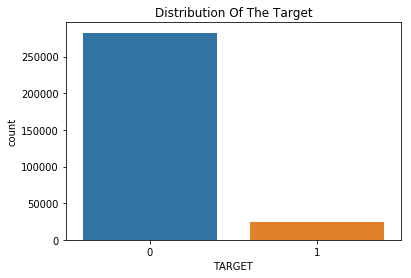

In [24]:
sns.countplot(x="TARGET", 
              data=app_train)
plt.title('distribution of the target'.title())
# plt.yscale('log')
plt.savefig("Dist_Target.png")
plt.show()


**This is an imbalanced class problem**.
There are far more loans that were repaid on time than loans that were not repaid.<br>
We have Two methods to work with:<br>
    <ol>
    <li> Algorithm Level.</li>
    <li> Data Level.</li>
    </ol>

## Types of loan

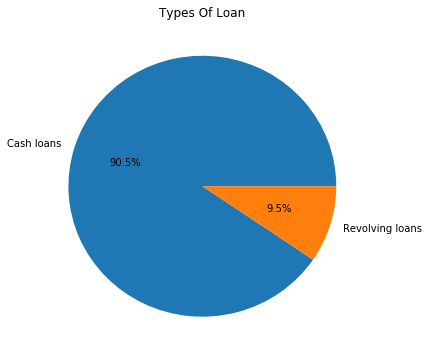

In [25]:
loan_types = (app_train
                 .NAME_CONTRACT_TYPE
                 .value_counts())
plt.figure(figsize=(6,6))
plt.title('Types of loan'.title())
plt.pie(loan_types.values, labels=loan_types.index, autopct='%1.1f%%')
plt.savefig("Type_Loan.png")
plt.show()

* Most of the loans are Cash loans which were taken by applicants

## Types of Gender

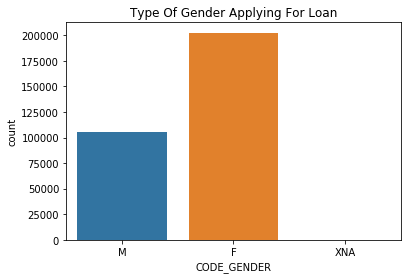

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x='CODE_GENDER',
              data=app_train
             )
plt.title("Type Of Gender applying for loan".title())
plt.savefig("Gender.png")
plt.show()

> There are *missing values*

## Purpose of Loan

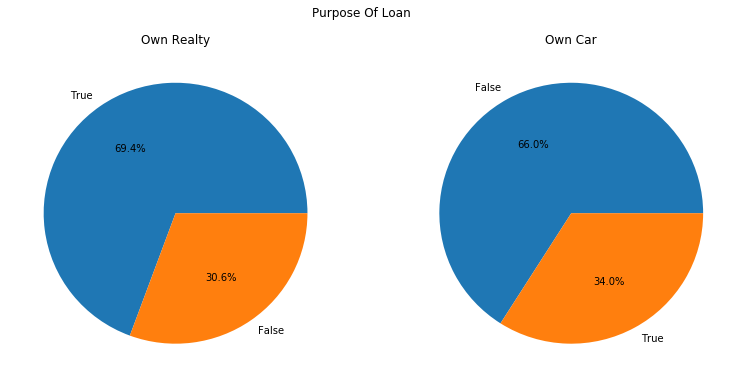

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,6))
realty = (app_train
          .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}))
          .FLAG_OWN_REALTY
          .value_counts())

car = (app_train
          .assign(FLAG_OWN_CAR = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}))
          .FLAG_OWN_CAR
          .value_counts())

fig.suptitle('Purpose of loan'.title())
ax1.pie(realty.values, labels=realty.index, autopct='%1.1f%%')
ax1.title.set_text('Own Realty')
ax2.pie(car.values, labels=car.index, autopct='%1.1f%%')
ax2.title.set_text('Own Car')
plt.savefig("Purpose_loan.png")
plt.show()


## Income sources of Applicant's who applied for loan

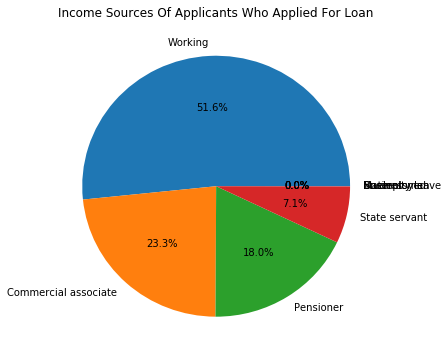

In [28]:
income_types = (app_train
                 .NAME_INCOME_TYPE
                 .value_counts())

plt.figure(figsize=(6,6))
plt.title('Income sources of Applicants who applied for loan'.title())
plt.pie(income_types.values, labels=income_types.index, autopct='%1.1f%%')
plt.savefig("Income_Source.png")
plt.show()

## Family Status of Applicant's who applied for loan

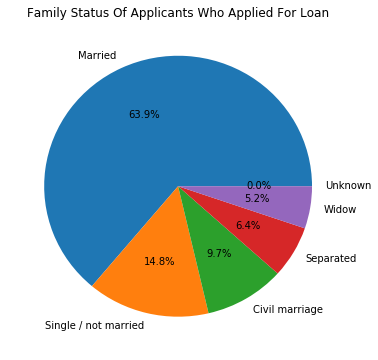

In [29]:
family_status = (app_train
                 .NAME_FAMILY_STATUS
                 .value_counts())

plt.figure(figsize=(6,6))
plt.title('Family Status of Applicants who applied for loan'.title())
plt.pie(family_status.values, labels=family_status.index, autopct='%1.1f%%')
plt.savefig("family.png")
plt.show()

* 63.9 % applicants are `married`.

## Education of Applicant's who applied for loan

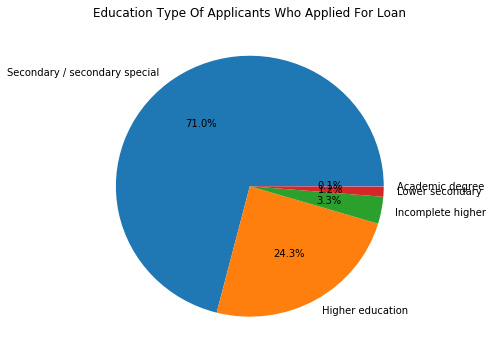

In [30]:
edu_type = (app_train
                 .NAME_EDUCATION_TYPE
                 .value_counts())

plt.figure(figsize=(6,6))
plt.title('Education type of Applicants who applied for loan'.title())
plt.pie(edu_type.values, labels=edu_type.index, autopct='%1.1f%%')
plt.savefig("edu.png")
plt.show()

## Types of house higher applicant's applied for loan

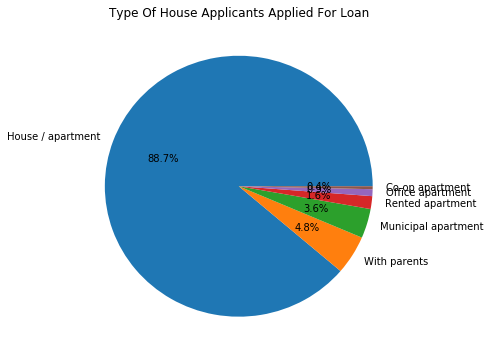

In [31]:
house_type = (app_train
                 .NAME_HOUSING_TYPE
                 .value_counts())

plt.figure(figsize=(6,6))
plt.title('Type of house Applicants applied for loan'.title())
plt.pie(house_type.values, labels=house_type.index, autopct='%1.1f%%')
plt.savefig("house.png")
plt.show()

* *88.7* % of peoples applied for loan, mentioned type of house is `House / Appartment`.

## Distribution of AMT_CREDIT

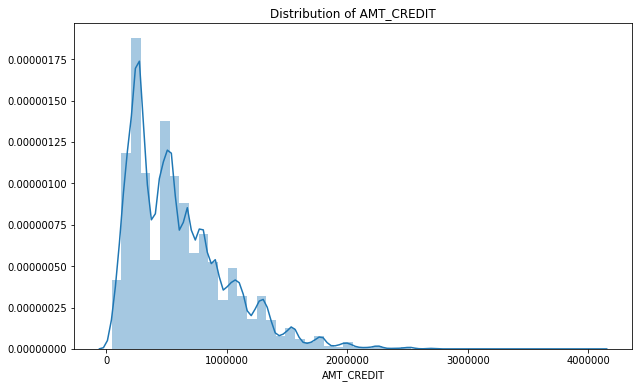

In [32]:
plt.figure(figsize=(10,6))
plt.title("Distribution of AMT_CREDIT")
sns.distplot(app_train.AMT_CREDIT)
plt.savefig("AMT_CREDIT.png")
plt.show()

## Who Accompanied Client When Applying For The Application

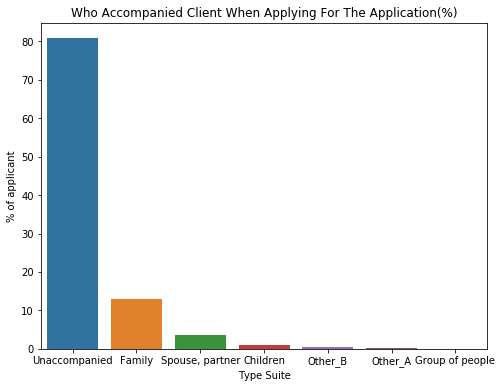

In [33]:
accompain = app_train.NAME_TYPE_SUITE.value_counts().mul(100).div(app_train.shape[0])

plt.figure(figsize=(8,6))
sns.barplot(x=accompain.index, 
              y=accompain)
plt.title('Who accompanied client when applying for the application(%)'.title())
plt.xlabel('Type Suite')
plt.ylabel('% of applicant')
plt.savefig('suite.png')
plt.show()

## Occupation of Applicant's who applied for loan

Laborers       17.946025
Sales staff    10.439301
Core staff      8.965533
Managers        6.949670
Name: OCCUPATION_TYPE, dtype: float64


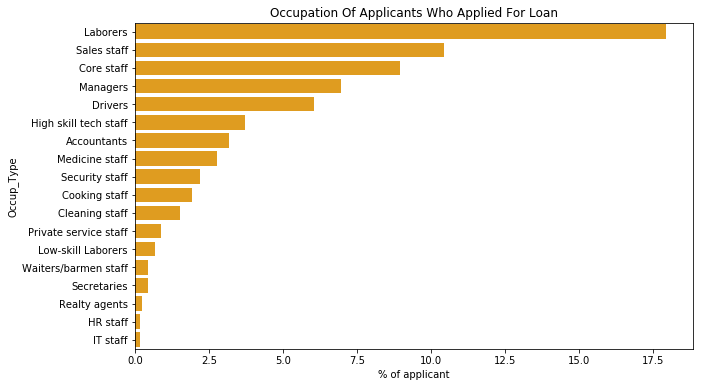

In [34]:
occup = app_train.OCCUPATION_TYPE.value_counts().mul(100).div(app_train.shape[0])
print(occup[:4])
plt.figure(figsize=(10,6))
sns.barplot(y=occup.index, 
              x=occup,
             color='orange')
plt.title('occupation of Applicants who applied for loan'.title())
plt.xlabel('% of applicant')
plt.ylabel('Occup_Type')
plt.savefig('occup.png')
plt.show()

* Types of Occupation:
    * Approx. 18 %  -> Laborers
    * Approx. 10.5 %   -> Sales staff
    * Approx. 9 %  -> Core staff 
    * Approx. 7 %  -> Mangers

## Types of Organizations who applied for loan 

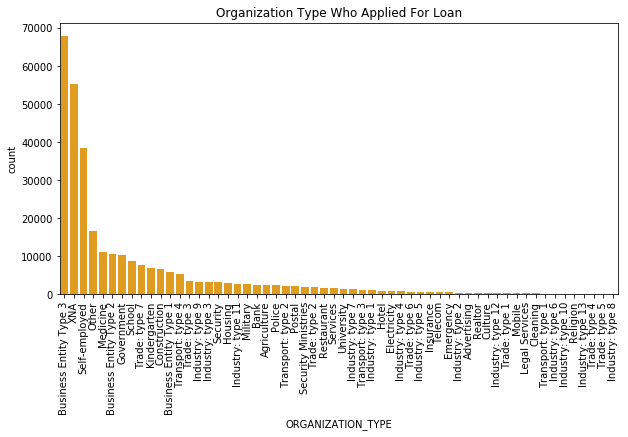

In [35]:
plt.figure(figsize=(10,5))
sns.countplot(x="ORGANIZATION_TYPE", 
              data=app_train,
             order = app_train['ORGANIZATION_TYPE'].value_counts().index,
             color='orange')
plt.title('ORGANIZATION TYPE who applied for loan'.title())
plt.xticks(rotation=90)
plt.show()

* Types of Organizations:
    * Approx. 68 K  -> Business Entity Type 3
    * Approx. 55 K  -> XNA
    * Approx. 38 K  -> Self employed 
    * Approx. 20 K  -> Other

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements.<br> One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method as we did.<br>

* The numbers in the `DAYS_EMPLOYED` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:

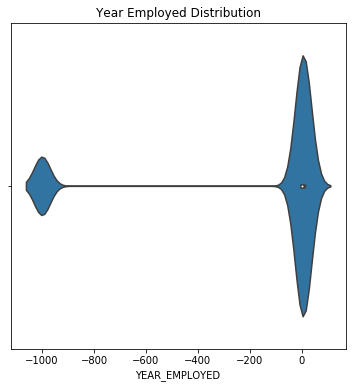

In [36]:
plt.figure(figsize=(6,6))
sns.violinplot(x=(app_train
                 .assign(FLAG_OWN_REALTY = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}),
                         FLAG_OWN_CAR    = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
                         YEAR_EMPLOYED    = app_train.DAYS_EMPLOYED.mul(-1).div(365)
                        )
                 .astype({col:'bool' for col in bool_cols})
                 .astype({col:'category' for col in cat_cols})
                ).YEAR_EMPLOYED
           )
plt.title('year employed distribution'.title())
plt.savefig('year_emp.png')
plt.show()

>  Despite the **Negative** value, He/She was`1000 year` old.<br>
We will *replace* it with `Null`, so we could *impute* it later, we will also create a new column to define its location, so we could recognize it from the actual Null values.

### Checking Family Members Counts

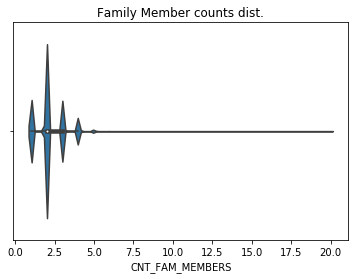

In [37]:
sns.violinplot(x= app_train.CNT_FAM_MEMBERS)
plt.title('Family Member counts dist.')
plt.show()

### Check FLAG_DOCUMENT_N

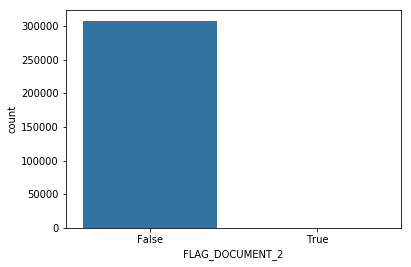

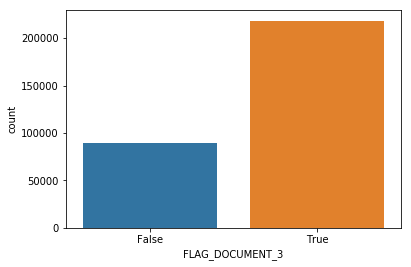

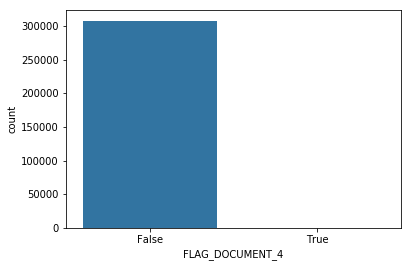

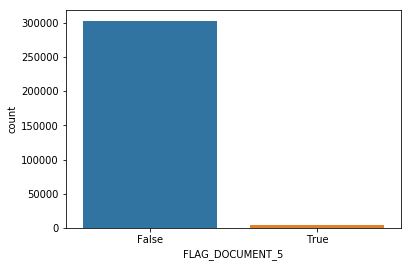

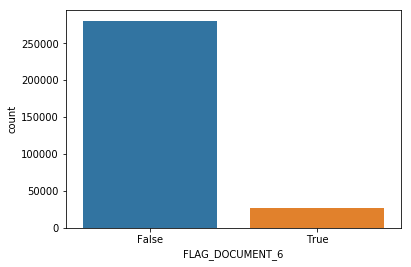

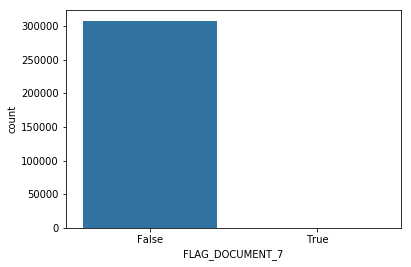

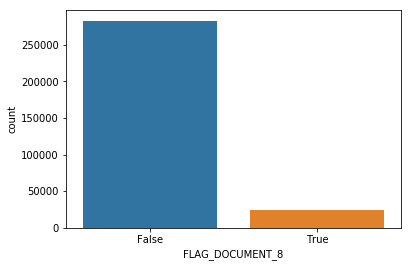

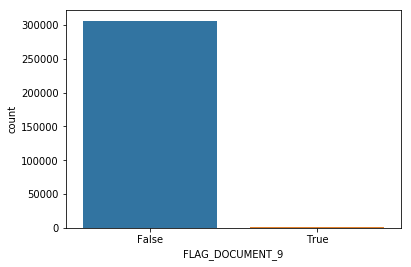

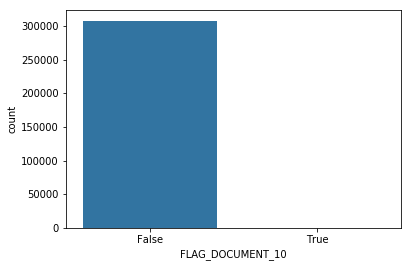

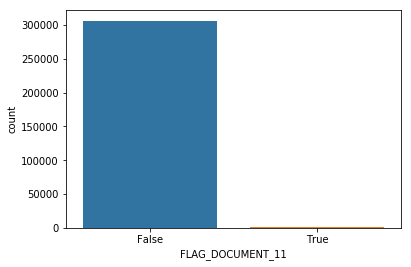

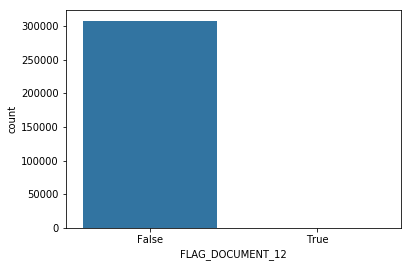

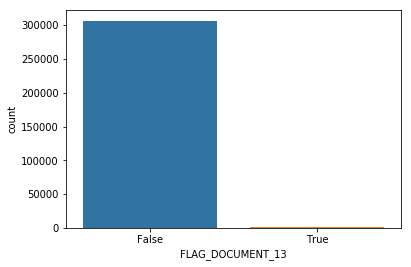

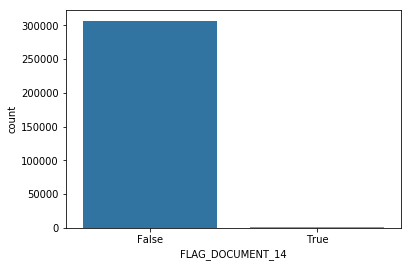

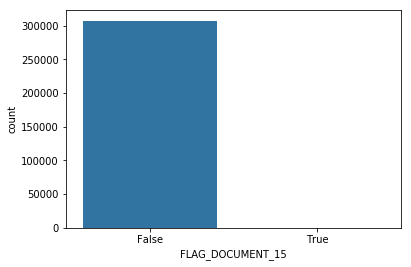

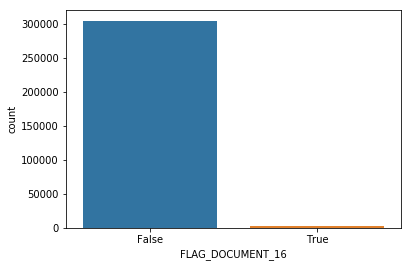

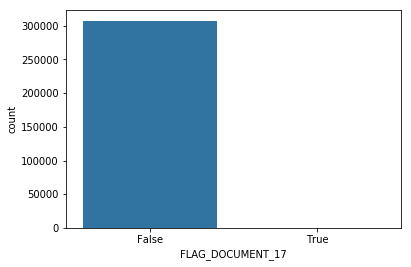

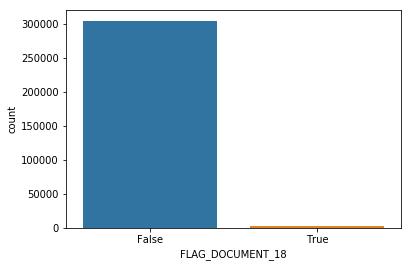

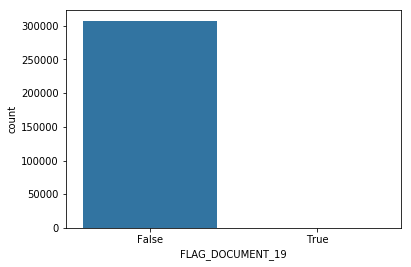

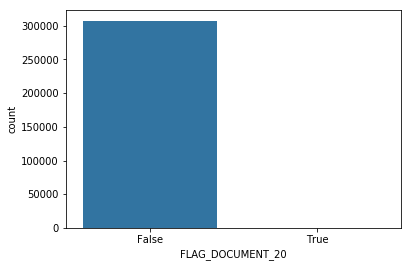

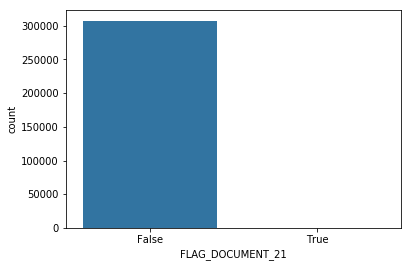

In [38]:
for i in range(2,22):
    sns.countplot(x=f'FLAG_DOCUMENT_{i}',
                  data=(app_train
                         .astype({col:'bool' for col in bool_cols})
                         )
                 )
#     plt.yscale('log')
    plt.show()

## Correlations

Looking for correlations between the features and the target.<br>
We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

In [39]:
# Find correlations with the target and sort
correlations = (app_train
                 .assign(CODE_GENDER        = app_train.CODE_GENDER.replace({'XNA':np.nan}),
                         FLAG_OWN_REALTY    = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}),
                         FLAG_OWN_CAR       = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
                         DAYS_EMPLOYED_ANOM = app_train.DAYS_EMPLOYED == 365243,
                         DAYS_EMPLOYED      = app_train.DAYS_EMPLOYED.replace({365243: np.nan})
                        )
                 .astype({col:'bool' for col in bool_cols})
                 .astype({col:'category' for col in cat_cols})
                 .corr()
                .sort_values(by='TARGET', ascending=False))

# Display correlations
print('Most Positive Correlations:\n', correlations['TARGET'].head(15))
print('\nMost Negative Correlations:\n', correlations['TARGET'].tail(15))


Most Positive Correlations:
 TARGET                         1.000000
DAYS_BIRTH                     0.078239
DAYS_EMPLOYED                  0.074958
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
Name: TARGET, dtype: float64

Most Negative Correlations:
 LIVINGAREA_MEDI              -0.032739
LIVINGAREA_AVG               -0.032997
FLOORSMIN_MEDI               -0.033394
FLOORSMIN_AVG                -0.033614
ELEVATORS_MEDI               -0.033863
ELEVATORS_AVG                -0.034199
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039645


Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!),<br>
Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!).<br>

### Who Has difficalities in repay

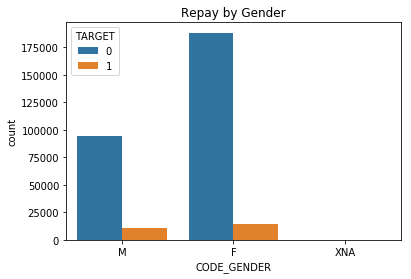

In [40]:
plt.figure(figsize=(6,4))
sns.countplot(x='CODE_GENDER',
              data=app_train,
              hue='TARGET'
             )
plt.title('Repay by Gender')
plt.savefig("Gender_T.png")
plt.show()

## Calculate the Average

In [41]:
gender = (app_train.groupby('CODE_GENDER')
         ['TARGET']     
         .mean()
        .mul(100))
gender

CODE_GENDER
F       6.999328
M      10.141920
XNA     0.000000
Name: TARGET, dtype: float64

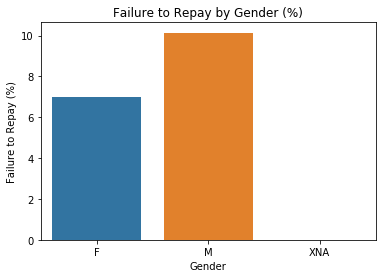

In [42]:
plt.figure(figsize = (6, 4))

# Graph the age bins and the average of the target as a bar plot
sns.barplot(gender.index, gender)

# Plot labeling
plt.xlabel('Gender')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Gender (%)')
plt.savefig("Gender_T_Av.png")

### Effect of Age on Repayment

> As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. <br>
We Will cut the age into Bins


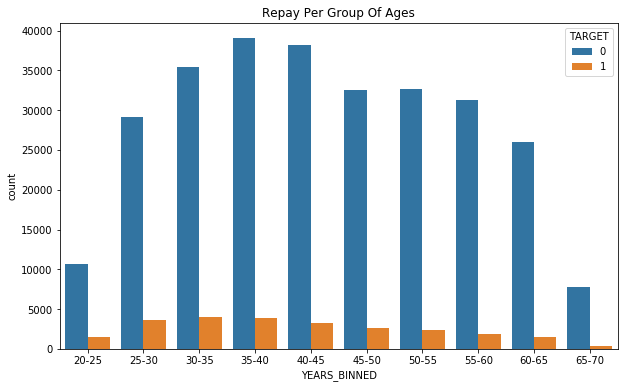

In [43]:
# Cut the age into Bins
plt.figure(figsize=(10,6))
sns.countplot(x='YEARS_BINNED',
              data=(app_train
                     .assign(
                             CLIENT_AGE         = app_train.DAYS_BIRTH.mul(-1).div(365)
                            )
                     .pipe(lambda df: df.assign(YEARS_BINNED = pd.cut(df['CLIENT_AGE'],
                                                                      bins = np.linspace(20, 70, num = 11),
                                                                      labels=[f'{i}-{i+5}' for i in np.arange(20,70,5)])))
                     .drop(columns=['DAYS_BIRTH'])
                    ),
              hue = 'TARGET'
             )
#     plt.yscale('log')
plt.title('Repay per Group of ages'.title())
plt.savefig('repay_age.png')
plt.show()

* Calculate the % of Failure to Repay for each group 

In [44]:
age_groups = (app_train
             .assign(
                     CLIENT_AGE         = app_train.DAYS_BIRTH.mul(-1).div(365)
                    )
             .pipe(lambda df: df.assign(YEARS_BINNED = pd.cut(df['CLIENT_AGE'],
                                                              bins = np.linspace(20, 70, num = 11),
                                                              labels=[f'{i}-{i+5}' for i in np.arange(20,70,5)])))
              
             .drop(columns=['DAYS_BIRTH'])
             .groupby('YEARS_BINNED')
              ['TARGET']
              .mean()
              .mul(100)
             )
age_groups

YEARS_BINNED
20-25    12.303643
25-30    11.143570
30-35    10.281440
35-40     8.941402
40-45     7.849104
45-50     7.417105
50-55     6.696812
55-60     5.531401
60-65     5.273693
65-70     3.727015
Name: TARGET, dtype: float64

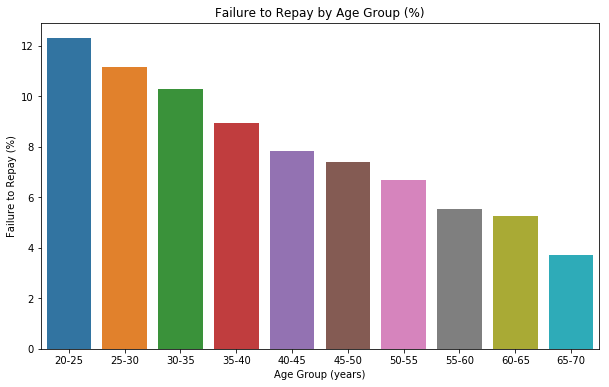

In [45]:
plt.figure(figsize = (10, 6))

# Graph the age bins and the average of the target as a bar plot
sns.barplot(age_groups.index, age_groups)

# Plot labeling
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group (%)')
plt.savefig('repay_age_avg.png')

There is a clear trend: `younger` applicants are more likely to `not repay` the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank:<br>
Because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.<br>
* We can show the correlations of the `EXT_SOURCE` features with the target.

In [46]:
# Extract the EXT_SOURCE variables and show correlations
ext_data_corrs = (app_train
                 .loc[:,['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
                 .corr())
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.155317,-0.160472,-0.178919
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000


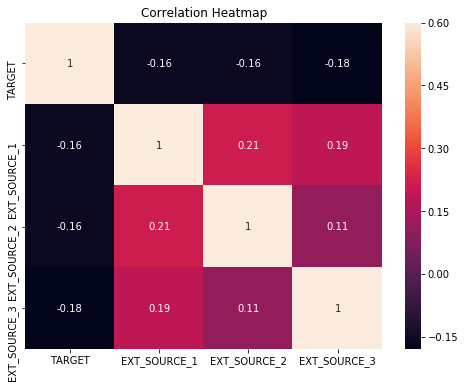

In [47]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


All three `EXT_SOURCE` features have negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan.

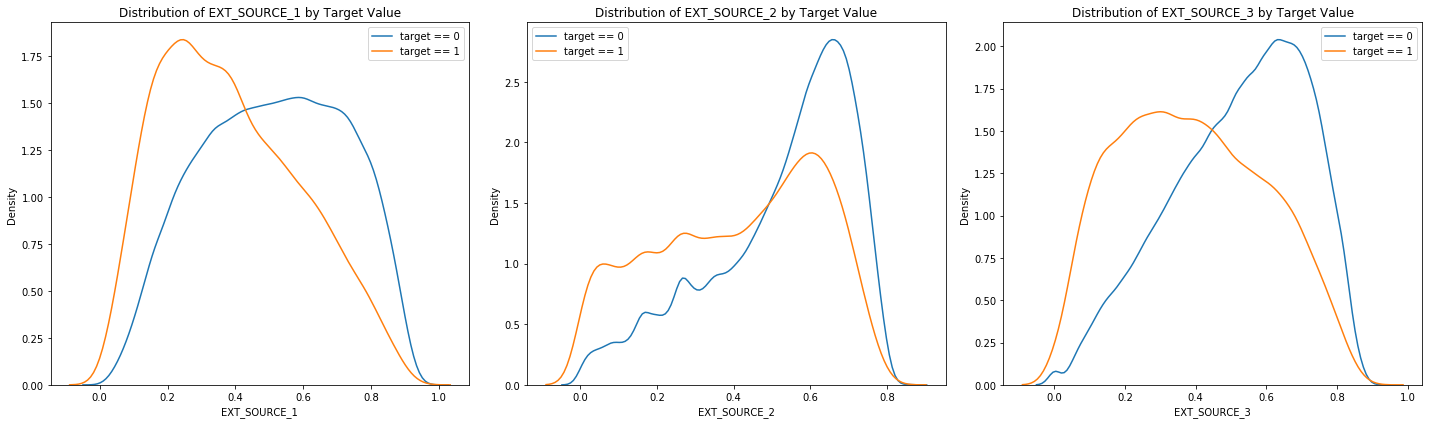

In [48]:
plt.figure(figsize = (20, 6))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(1, 3, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.savefig('ext_source.png')
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target.<br> We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is `not` very strong (in fact they are all considered `very weak`), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pearson Correlation of features

In [49]:
correlations = (app_train
                 .assign(CODE_GENDER        = app_train.CODE_GENDER.replace({'XNA':np.nan}),
                         FLAG_OWN_REALTY    = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}),
                         FLAG_OWN_CAR       = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
                         DAYS_EMPLOYED      = app_train.DAYS_EMPLOYED.replace({365243: np.nan}),
                         CLIENT_AGE         = app_train.DAYS_BIRTH.mul(-1).div(365)
                        )
                 .pipe(lambda df: df.assign(YEARS_BINNED = pd.cut(df['CLIENT_AGE'],
                                                                  bins = np.linspace(20, 70, num = 11),
                                                                  labels=[f'{i}-{i+5}' for i in np.arange(20,70,5)])))
                 .astype({col:'bool' for col in bool_cols})
                 .astype({col:'category' for col in cat_cols})
                 .drop(columns=['DAYS_BIRTH','CLIENT_AGE','TARGET'])
                 .corr()
               )

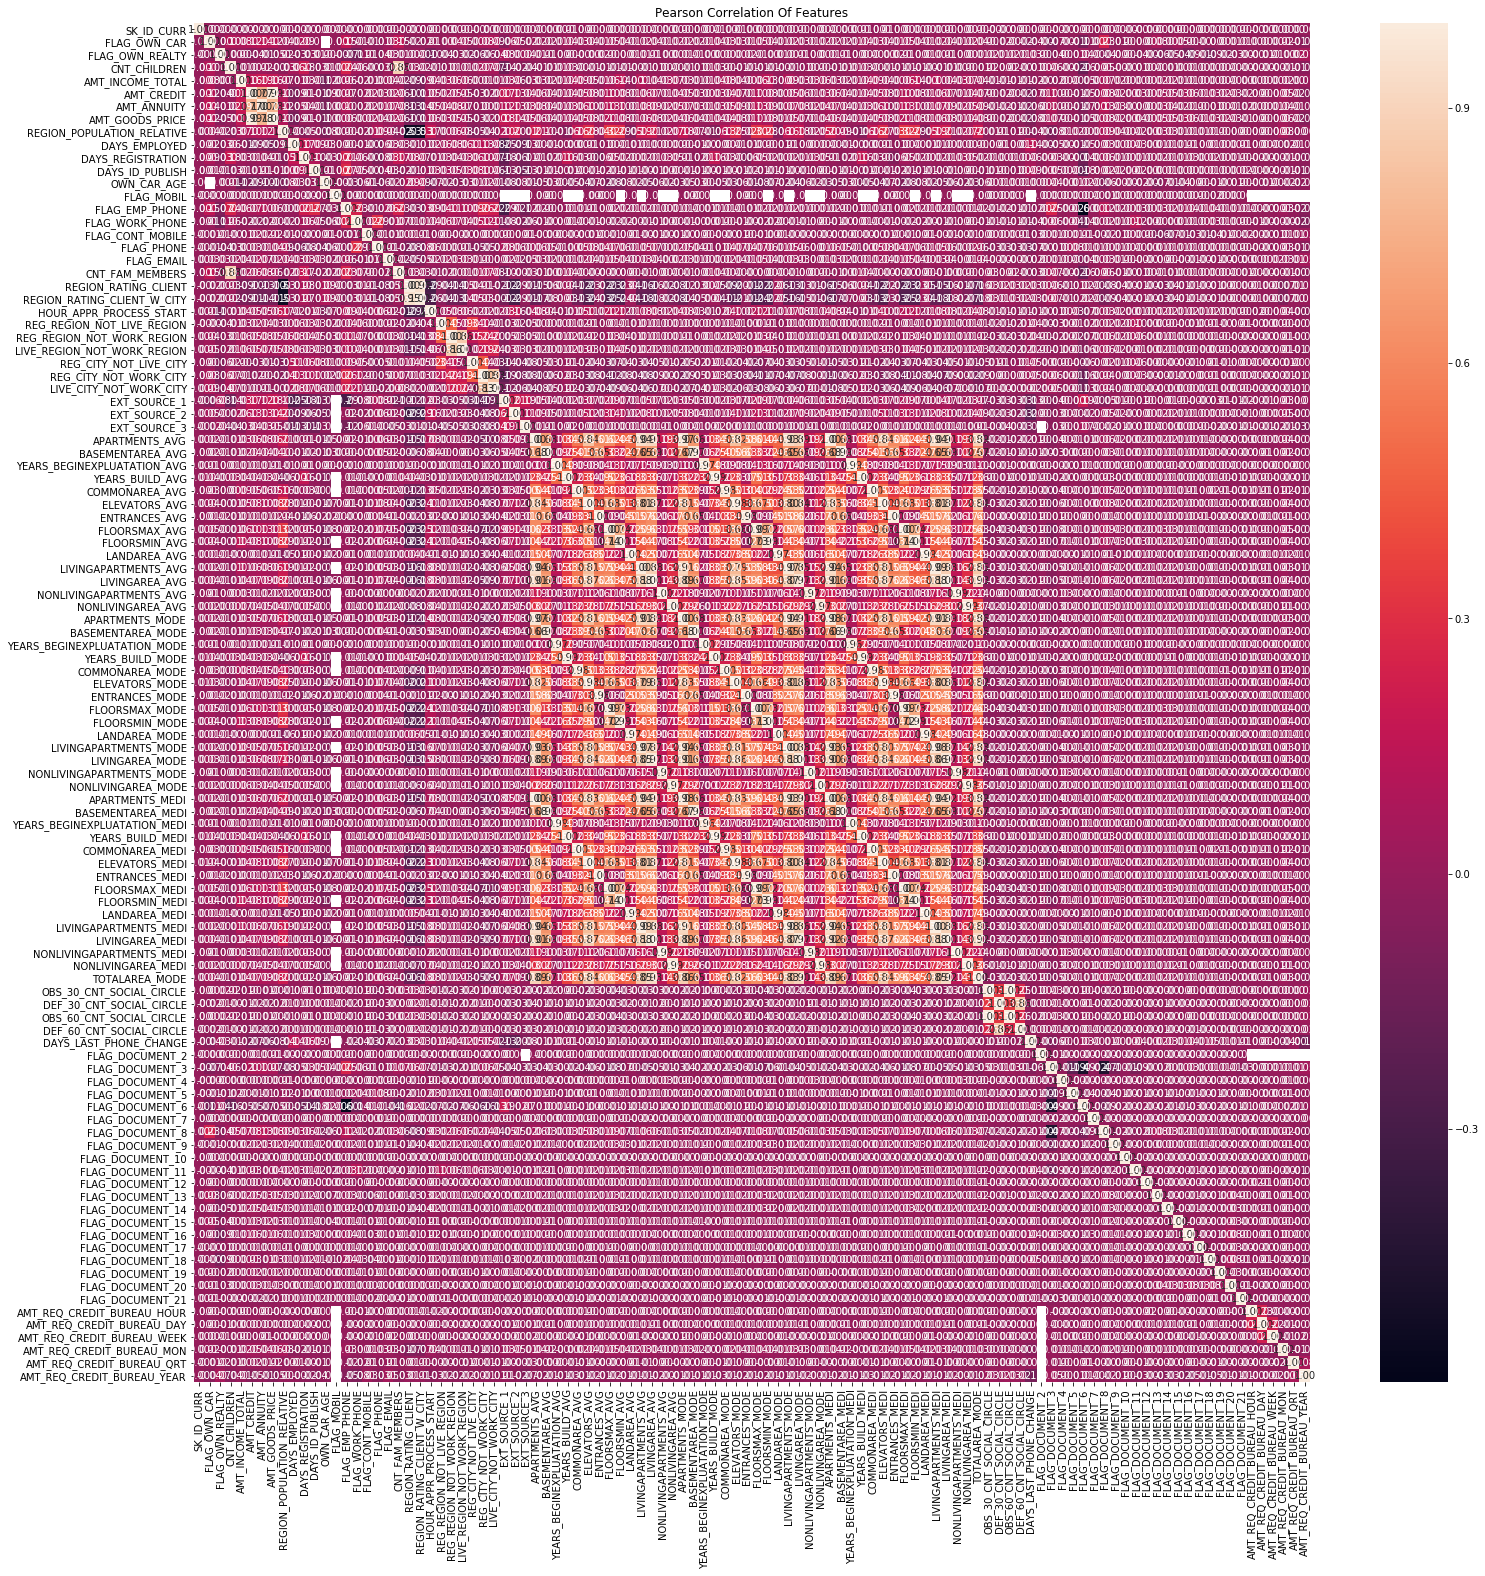

In [50]:
plt.figure(figsize=(25,25))
sns.heatmap(correlations, annot=True,fmt=".2f")
plt.title('Pearson Correlation of features'.title())
plt.savefig('corr_matrix.png')
plt.show()

* We will remove strong correlated features

# 4. Feature Engineering

Feature engineering refers to a general process and can involve both feature construction: <br> adding new features from the existing data, and feature selection (choosing only the most important features or other methods of dimensionality reduction). There are many techniques we can use to both create features and select features.

We will try only two simple feature construction methods: 

* Polynomial features
* Domain knowledge feature selection


## Remove strong correlated features
* Because there are some correlations, let's remove the correlated data that has more than 0.9 correlation.

In [51]:
def remove_corr(df,thresh=0.9):
    """
    remove_corr(df,thresh=0.85):
        return columns with thresh correlation to drop
    Parameters:
        df: pandas.DataFrame
            correlation_matrix
        thresh: float (optional), 0.9 default
            correlation threshold
    Return:
        removed_col: set()
            columns' name to be droped
    """
    removed_col=set()
    for col in df.columns:
        if col in removed_col:
            continue
        else:
            upper_thresh = (df[col]>=thresh)&(df[col]<1)
            lowwer_thresh = (df[col]<=-1*thresh)
            idx = np.where(upper_thresh | lowwer_thresh)
            temp = df.iloc[idx].index
            
            if len(temp):
                removed_col.update(list(temp))
    return list(removed_col)

In [52]:
corr_col = remove_corr(correlations,0.9)
print(corr_col)

['LANDAREA_MODE', 'NONLIVINGAREA_MODE', 'COMMONAREA_MEDI', 'NONLIVINGAREA_MEDI', 'FLOORSMIN_MODE', 'ELEVATORS_MEDI', 'AMT_GOODS_PRICE', 'YEARS_BEGINEXPLUATATION_MODE', 'LANDAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLOORSMIN_MEDI', 'ELEVATORS_MODE', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'LIVINGAREA_MEDI', 'APARTMENTS_MEDI', 'REGION_RATING_CLIENT_W_CITY', 'BASEMENTAREA_MODE', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'COMMONAREA_MODE', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'FLOORSMAX_MODE', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI']


In [53]:
df_train = (app_train
             .assign(CODE_GENDER        = app_train.CODE_GENDER.replace({'XNA':np.nan}),
                     FLAG_OWN_REALTY    = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}),
                     FLAG_OWN_CAR       = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
                     DAYS_EMPLOYED_ANOM = app_train.DAYS_EMPLOYED == 365243,
                     DAYS_EMPLOYED      = app_train.DAYS_EMPLOYED.replace({365243: np.nan}),
                     YEAR_EMPLOYED      = lambda r: r.DAYS_EMPLOYED.mul(-1).div(365),
                     CLIENT_AGE         = app_train.DAYS_BIRTH.mul(-1).div(365)
                    )
             .astype({col:'bool' for col in bool_cols})
             .astype({col:'category' for col in cat_cols})
             .drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED']+corr_col)
            )
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,...,NONLIVINGAREA_AVG,LIVINGAREA_MODE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,YEAR_EMPLOYED,CLIENT_AGE
0,100002,1,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-3648.0,-2120,NaN,True,True,False,True,True,False,Laborers,1.0,2,WEDNESDAY,10,False,False,False,False,False,False,Business Entity Type 3,0.083037,0.262949,0.139376,...,0.0000,0.0198,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,-1134.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,False,1.745205,25.920548
1,100003,0,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-1186.0,-291,NaN,True,True,False,True,True,False,Core staff,2.0,1,MONDAY,11,False,False,False,False,False,False,School,0.311267,0.622246,NaN,...,0.0098,0.0554,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,0.0,-828.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,3.254795,45.931507
2,100004,0,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-4260.0,-2531,26.0,True,True,True,True,True,False,Laborers,1.0,2,MONDAY,9,False,False,False,False,False,False,Government,NaN,0.555912,0.729567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-815.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,0.616438,52.180822
3,100006,0,Cash loans,F,False,True,0,135000.0,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-9833.0,-2437,NaN,True,True,False,True,False,False,Laborers,2.0,2,WEDNESDAY,17,False,False,False,False,False,False,Business Entity Type 3,NaN,0.650442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,-617.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,8.326027,52.068493
4,100007,0,Cash loans,M,False,True,0,121500.0,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-4311.0,-3458,NaN,True,True,False,True,False,False,Core staff,1.0,2,THURSDAY,11,False,False,False,False,True,True,Religion,NaN,0.322738,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-1106.0,False,False,Fals

In [54]:
df_test = (app_test
             .assign(CODE_GENDER        = app_train.CODE_GENDER.replace({'XNA':np.nan}),
                     FLAG_OWN_REALTY    = app_train.FLAG_OWN_REALTY.replace({'N':False,'Y':True}),
                     FLAG_OWN_CAR       = app_train.FLAG_OWN_CAR.replace({'N':False,'Y':True}),
                     DAYS_EMPLOYED_ANOM = app_train.DAYS_EMPLOYED == 365243,
                     DAYS_EMPLOYED      = app_train.DAYS_EMPLOYED.replace({365243: np.nan}),
                     YEAR_EMPLOYED      = lambda r: r.DAYS_EMPLOYED.mul(-1).div(365),
                     CLIENT_AGE         = app_train.DAYS_BIRTH.mul(-1).div(365)
                    )
                  
             .astype({col:'bool' for col in bool_cols})
             .astype({col:'category' for col in cat_cols})
             .drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED']+corr_col)
            )
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,...,NONLIVINGAREA_AVG,LIVINGAREA_MODE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,YEAR_EMPLOYED,CLIENT_AGE
0,100001,Cash loans,M,False,True,0,135000.0,568800.0,20560.5,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-5170.0,-812,NaN,True,True,False,True,False,True,NaN,2.0,2,TUESDAY,18,False,False,False,False,False,False,Kindergarten,0.752614,0.789654,0.159520,0.0660,...,NaN,0.0526,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,-1740.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,1.745205,25.920548
1,100005,Cash loans,F,False,False,0,99000.0,222768.0,17370.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-9118.0,-1623,NaN,True,True,False,True,False,False,Low-skill Laborers,2.0,2,FRIDAY,9,False,False,False,False,False,False,Self-employed,0.564990,0.291656,0.432962,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,3.0,False,3.254795,45.931507
2,100013,Cash loans,M,True,True,0,202500.0,663264.0,69777.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-2175.0,-3503,5.0,True,True,False,True,False,False,Drivers,2.0,2,MONDAY,14,False,False,False,False,False,False,Transport: type 3,NaN,0.699787,0.610991,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-856.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,1.0,4.0,False,0.616438,52.180822
3,100028,Cash loans,F,False,True,2,315000.0,1575000.0,49018.5,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-2000.0,-4208,NaN,True,True,False,True,True,False,Sales staff,4.0,2,WEDNESDAY,11,False,False,False,False,False,False,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,...,0.08,0.3827,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,-1805.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,3.0,False,8.326027,52.068493
4,100038,Cash loans,M,False,True,1,180000.0,625500.0,32067.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-4000.0,-4262,16.0,True,True,True,True,False,False,NaN,3.0,2,FRIDAY,5,False,False,False,False,True,True,Business Entity Type 3,0.202145,0.425687,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,-821.0,False,True,False,False,False,False,False,False,False,F

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 91 columns):
SK_ID_CURR                     307511 non-null int64
TARGET                         307511 non-null int64
NAME_CONTRACT_TYPE             307511 non-null category
CODE_GENDER                    307507 non-null category
FLAG_OWN_CAR                   307511 non-null bool
FLAG_OWN_REALTY                307511 non-null bool
CNT_CHILDREN                   307511 non-null int64
AMT_INCOME_TOTAL               307511 non-null float64
AMT_CREDIT                     307511 non-null float64
AMT_ANNUITY                    307499 non-null float64
NAME_TYPE_SUITE                306219 non-null category
NAME_INCOME_TYPE               307511 non-null category
NAME_EDUCATION_TYPE            307511 non-null category
NAME_FAMILY_STATUS             307511 non-null category
NAME_HOUSING_TYPE              307511 non-null category
REGION_POPULATION_RELATIVE     307511 non-null float64
DAYS_REGISTRAT

## Handle Missing Values

* Drop columns in which more than 60% of the values are missing.
* Fillna numeric with Median, Categorical with Mode

In [56]:
df_miss = missing_values(df_train)

In [57]:
miss_cols = list(df_miss[df_miss['% of Total Data']>60].index)
miss_cols

['COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'FONDKAPREMONT_MODE',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE']

In [58]:
df_train.drop(columns=miss_cols,inplace=True)

In [59]:
df_test.drop(columns=miss_cols,inplace=True)

* Impute missing values

In [60]:
mode_fill = df_train.select_dtypes(exclude=np.number).mode().iloc[0].to_dict()
median_fill = df_train.select_dtypes(np.number).median().to_dict()


In [63]:
fill = {**mode_fill,**median_fill}
fill

{'NAME_CONTRACT_TYPE': 'Cash loans',
 'CODE_GENDER': 'F',
 'FLAG_OWN_CAR': False,
 'FLAG_OWN_REALTY': True,
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'NAME_INCOME_TYPE': 'Working',
 'NAME_EDUCATION_TYPE': 'Secondary / secondary special',
 'NAME_FAMILY_STATUS': 'Married',
 'NAME_HOUSING_TYPE': 'House / apartment',
 'FLAG_MOBIL': True,
 'FLAG_EMP_PHONE': True,
 'FLAG_WORK_PHONE': False,
 'FLAG_CONT_MOBILE': True,
 'FLAG_PHONE': False,
 'FLAG_EMAIL': False,
 'OCCUPATION_TYPE': 'Laborers',
 'WEEKDAY_APPR_PROCESS_START': 'TUESDAY',
 'REG_REGION_NOT_LIVE_REGION': False,
 'REG_REGION_NOT_WORK_REGION': False,
 'LIVE_REGION_NOT_WORK_REGION': False,
 'REG_CITY_NOT_LIVE_CITY': False,
 'REG_CITY_NOT_WORK_CITY': False,
 'LIVE_CITY_NOT_WORK_CITY': False,
 'ORGANIZATION_TYPE': 'Business Entity Type 3',
 'HOUSETYPE_MODE': 'block of flats',
 'WALLSMATERIAL_MODE': 'Panel',
 'EMERGENCYSTATE_MODE': 'No',
 'FLAG_DOCUMENT_2': False,
 'FLAG_DOCUMENT_3': True,
 'FLAG_DOCUMENT_4': False,
 'FLAG_DOCUMENT_5': False,

In [64]:
df_train.fillna(fill,inplace=True)

In [65]:
df_test.fillna(fill,inplace=True)

## Encoding Categorical Variables

Before we go any further, we need to deal with categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM]
There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below


* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. If we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.
 
I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by PCA or other dimensionality reduction methods
 to reduce the number of dimensions (while still trying to preserve information). 


### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [66]:
# Create a label encoder object
labelEncoders= {}
# Iterate through the columns
for col in df_train:
    if df_train[col].dtype.name == 'category':
        # If 2 or fewer unique categories
        le = LabelEncoder()
        nunique = df_train[col].nunique()
        if nunique <= 2:
            # Train on the training data
            le.fit(df_train[col])
            labelEncoders[col]=le
            df_train[col] = le.transform(df_train[col])
            df_test[col] = le.transform(df_test[col])

print(f'{labelEncoders.keys()} columns were label encoded.')

dict_keys(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'EMERGENCYSTATE_MODE']) columns were label encoded.


In [67]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,...,LANDAREA_AVG,NONLIVINGAREA_AVG,LIVINGAREA_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,YEAR_EMPLOYED,CLIENT_AGE
0,100002,1,0,1,False,True,0,202500.0,406597.5,24700.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-3648.0,-2120,True,True,False,True,True,False,Laborers,1.0,2,WEDNESDAY,10,False,False,False,False,False,False,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,...,0.0369,0.0000,0.0198,block of flats,0.0149,"Stone, brick",0,2.0,2.0,2.0,-1134.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,False,1.745205,25.920548
1,100003,0,0,0,False,False,0,270000.0,1293502.5,35698.5,Family,State servant,Higher education,Married,House / apartment,0.003541,-1186.0,-291,True,True,False,True,True,False,Core staff,2.0,1,MONDAY,11,False,False,False,False,False,False,School,0.311267,0.622246,0.535276,0.0959,...,0.0130,0.0098,0.0554,block of flats,0.0714,Block,0,1.0,0.0,0.0,-828.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,3.254795,45.931507
2,100004,0,1,1,True,True,0,67500.0,135000.0,6750.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-4260.0,-2531,True,True,True,True,True,False,Laborers,1.0,2,MONDAY,9,False,False,False,False,False,False,Government,0.505998,0.555912,0.729567,0.0876,...,0.0481,0.0036,0.0731,block of flats,0.0688,Panel,0,0.0,0.0,0.0,-815.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,False,0.616438,52.180822
3,100006,0,0,0,False,True,0,135000.0,312682.5,29686.5,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-9833.0,-2437,True,True,False,True,False,False,Laborers,2.0,2,WEDNESDAY,17,False,False,False,False,False,False,Business Entity Type 3,0.505998,0.650442,0.535276,0.0876,...,0.0481,0.0036,0.0731,block of flats,0.0688,Panel,0,2.0,0.0,0.0,-617.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,False,8.326027,52.068493
4,100007,0,0,1,False,True,0,121500.0,513000.0,21865.5,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-4311.0,-3458,True,True,False,True,False,False,Core staff,1.0,2,THURSDAY,11,False,False,False,False,True,True,Religion,0.505998,0.322738,0.535276,0.0876,...,0.0481,0.0036,0.0731,block of flats,0.0688,Panel,

## One-hot Encoding

In [68]:

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 200)
Testing Features shape:  (48744, 197)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [69]:
train_labels = df_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

# Add the target back in
df_train['TARGET'] = train_labels

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (307511, 198)
Testing Features shape:  (48744, 197)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

## Polynomial Features

In [70]:
# Make a new dataframe for polynomial features
poly_features = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CLIENT_AGE', 'TARGET']]
poly_features_test = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CLIENT_AGE']]

# # imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [71]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [72]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'CLIENT_AGE'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CLIENT_AGE',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 CLIENT_AGE',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 CLIENT_AGE',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 CLIENT_AGE',
 'CLIENT_AGE^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [73]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'CLIENT_AGE']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 CLIENT_AGE     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 CLIENT_AGE                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
CLIENT_AGE     -0.078239
CLIENT_AGE^2   -0.076672
CLIENT_AGE^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn. 

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out! 

In [74]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = df_train['SK_ID_CURR']
app_train_poly = df_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = df_test['SK_ID_CURR']
app_test_poly = df_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 216)
Testing data with polynomial features shape:   (48744, 216)


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [75]:
app_train_domain = df_train.copy()
app_test_domain = df_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['YEAR_EMPLOYED_PERCENT'] = app_train_domain['YEAR_EMPLOYED'] / app_train_domain['CLIENT_AGE']

In [76]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['YEAR_EMPLOYED_PERCENT'] = app_test_domain['YEAR_EMPLOYED'] / app_test_domain['CLIENT_AGE']

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

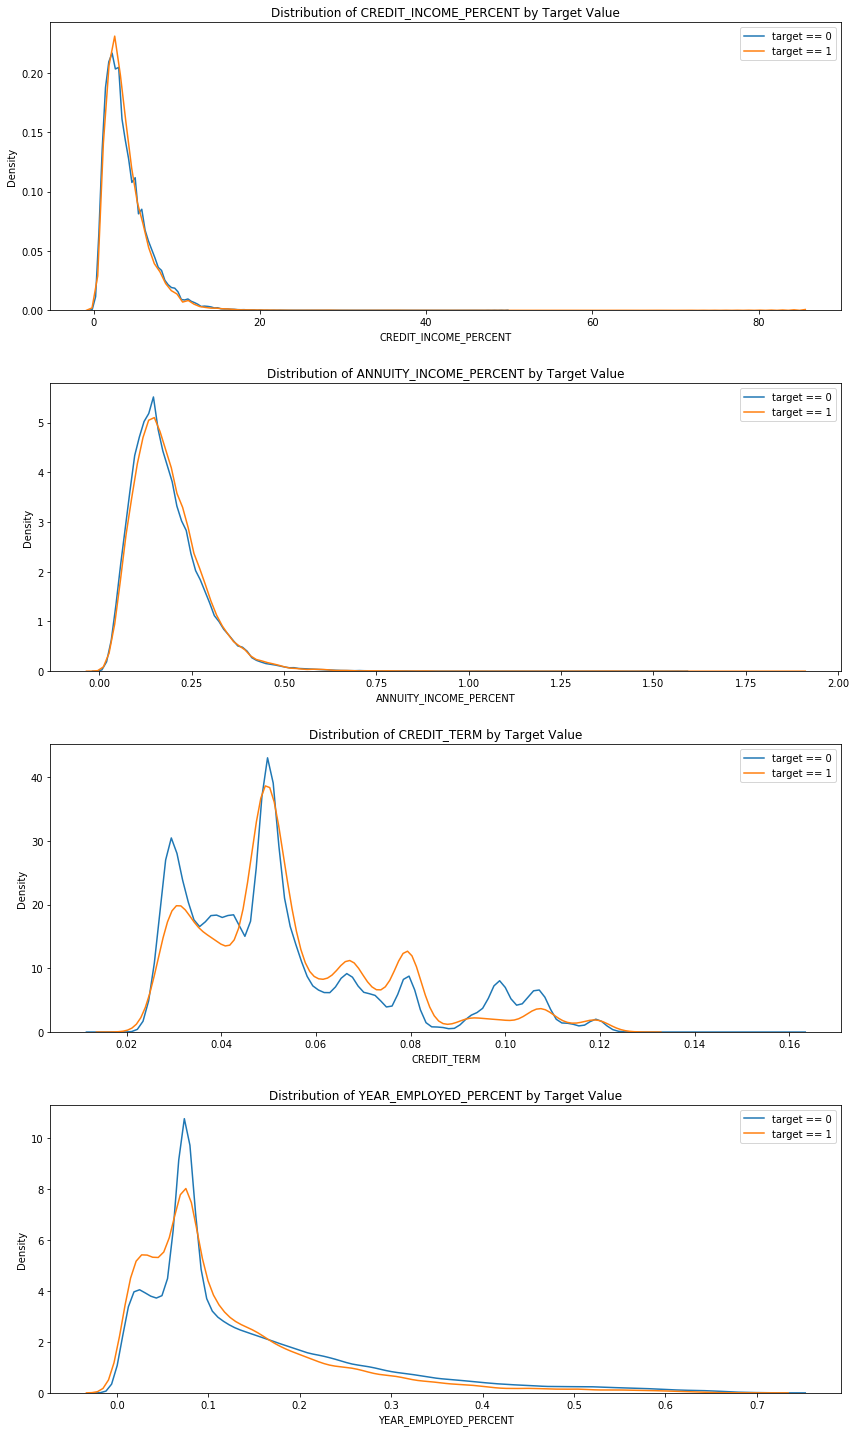

In [77]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'YEAR_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out! 

# 5. Model

## Metric
* **ROC AUC** Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

In [78]:
from sklearn.metrics import roc_auc_score

In [79]:
# Drop the target from the training data
X = df_train.drop(columns = ['TARGET'])
y = df_train[['TARGET']]

# Feature names
features = list(X.columns)

# Copy of the testing data
test = df_test.copy()

print('Training data shape: ', X.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 197)
Testing data shape:  (48744, 197)


## Model Training and Selection

In [80]:
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score


In [81]:
def kfold_model(model, X, y, k):
    """
        Evaluate a model using kfold cross validation
    Parameters:
    -------------------------
        model:estimator()
            model to evaluate
        X: pandas dataframe
            features
        y: pandas sereis
            labels/target column
        k: int
            number of kfold
    Return:
    --------------------------
        scores: list
            model scores
    """
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    train_scores = []
    valide_scores = []
    i=0
    for train, val in kfold.split(X,y):
        i+=1
        x_train, x_val = X.iloc[train,:], X.iloc[val,:]
        y_train, y_val = y.iloc[train], y.iloc[val]
        
        model.fit(x_train,y_train)
        print('*'*10,'{} fold'.format(i),'*'*10)
        pred_train =model.predict_proba(x_train)[:, 1]
        pred_val = model.predict_proba(x_val)[:, 1]      
        
        train_score = roc_auc_score(y_train,pred_train, average='weighted')
        valide_score = roc_auc_score(y_val,pred_val, average='weighted')
        
        train_scores.append(train_score)
        valide_scores.append(valide_score)
        
        print('train: {} \t validate: {}'.format(train_score,valide_score),'*'*10)
    print('Mean train: {} \t validate: {}'.format(np.mean(train_scores),np.mean(valide_scores)),'*'*10)

In [82]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

## Random Forest
* Random Forest is a tree-based model and hence does not require feature scaling

In [102]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, class_weight="balanced", random_state = 50, verbose = 1, n_jobs = -1)

In [103]:
kfold_model(random_forest, X, y, 3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.6s finished


********** 1 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.8s finished


train: 1.0 	 validate: 0.7217449461601212 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.9s finished


********** 2 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.9s finished


train: 1.0 	 validate: 0.7230123310509311 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.0s finished


********** 3 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s


train: 1.0 	 validate: 0.7186208889487951 **********
Mean train: 1.0 	 validate: 0.7211260553866158 **********


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.8s finished


## Light Gradient Boosting Machine

The [gradient boosting machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) using the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html)!

In [104]:
import lightgbm as lgb
import gc

def model(features,labels, n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        n_folds (int, default = 5): 
            number of folds to use for cross validation
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iterationcvcv
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [105]:
fi_base, metrics = model(X, y.TARGET,3)
print('Baseline metrics')
print(metrics)

Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.750925	train's auc: 0.799659
Early stopping, best iteration is:
[235]	valid's auc: 0.751172	train's auc: 0.806217
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.756888	train's auc: 0.797435
[400]	valid's auc: 0.757903	train's auc: 0.833776
Early stopping, best iteration is:
[325]	valid's auc: 0.758046	train's auc: 0.821036
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.754741	train's auc: 0.798996
[400]	valid's auc: 0.75472	train's auc: 0.835126
Early stopping, best iteration is:
[317]	valid's auc: 0.755311	train's auc: 0.821264
Baseline metrics
      fold     train     valid
0        0  0.806217  0.751172
1        1  0.821036  0.758046
2        2  0.821264  0.755311
3  overall  0.816173  0.754798


# 6. Model Evaluation

In [106]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X
                                               ,y.TARGET
                                               ,test_size=0.2
                                               , random_state=42
                                               , shuffle=True
                                               , stratify=y['TARGET']
                                              )

In [107]:
model1 = RandomForestClassifier(n_estimators = 100, class_weight="balanced", random_state = 50, verbose = 1, n_jobs = -1)
# fit model
model1.fit(X_train, y_train)
pred_prob1 = model1.predict_proba(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


In [108]:
# Create the model
model2 = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                           class_weight = 'balanced', learning_rate = 0.05, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 50)

# Train the model
model2.fit(X_train, y_train, eval_metric = 'auc', verbose = 200)

# Record the out of fold predictions
pred_prob2 = model2.predict_proba(X_test)


In [109]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=0)

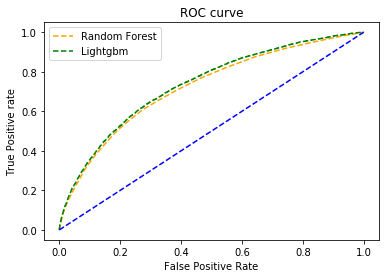

In [110]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Lightgbm')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label 
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC.png',dpi=300)
plt.show();

In [111]:
print('ROCAUC for LightGBM: {}',roc_auc_score(y_test, pred_prob2[:,1]))
print('ROCAUC for RandomForest: {}',roc_auc_score(y_test, pred_prob1[:,1]))


ROCAUC for LightGBM: {} 0.7342692419400341
ROCAUC for RandomForest: {} 0.7206770040536683


## Iterate Over Step 4,5,6

### Random Forest With Poly Features

In [112]:
poly_features_names = list(app_train_poly.columns)
random_forest_poly = RandomForestClassifier(n_estimators = 100, class_weight="balanced", random_state = 50, verbose = 1, n_jobs = -1)

In [113]:
kfold_model(random_forest_poly, app_train_poly, y, 3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.1s finished


********** 1 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.7s finished


train: 1.0 	 validate: 0.7210583518027801 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.3s finished


********** 2 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.1s finished


train: 1.0 	 validate: 0.7178422502818951 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   49.2s finished


********** 3 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s


train: 1.0 	 validate: 0.7183110875761011 **********
Mean train: 1.0 	 validate: 0.7190705632202588 **********


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.8s finished


### LGB With Poly Features

In [114]:
fi_poly, metrics = model(app_train_poly, y.TARGET,3)
print('Baseline metrics')
print(metrics)

Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.748653	train's auc: 0.799077
Early stopping, best iteration is:
[211]	valid's auc: 0.748866	train's auc: 0.801227
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.754093	train's auc: 0.796891
Early stopping, best iteration is:
[292]	valid's auc: 0.754696	train's auc: 0.815262
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.752105	train's auc: 0.798561
Early stopping, best iteration is:
[219]	valid's auc: 0.752216	train's auc: 0.802337
Baseline metrics
      fold     train     valid
0        0  0.801227  0.748866
1        1  0.815262  0.754696
2        2  0.802337  0.752216
3  overall  0.806275  0.751904


### Random Forest With Domain Features

Now we can test the domain features we made by hand.

In [115]:
X_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(X_domain.columns)

random_forest_domain = RandomForestClassifier(n_estimators = 100, class_weight="balanced", random_state = 50, verbose = 1, n_jobs = -1)

In [116]:
kfold_model(random_forest_domain, X_domain, y, 3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.3s finished


********** 1 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.1s finished


train: 1.0 	 validate: 0.726569958337981 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.1s finished


********** 2 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.2s finished


train: 0.9999999999999999 	 validate: 0.7231585160263456 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.4s finished


********** 3 fold **********


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s


train: 1.0 	 validate: 0.7238472506167788 **********
Mean train: 1.0 	 validate: 0.7245252416603685 **********


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


### LGB With Domain Features


In [117]:
fi_domain, metrics = model(X_domain, y.TARGET,3)
print('Baseline metrics')
print(metrics)

Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.760442	train's auc: 0.806855
[400]	valid's auc: 0.760674	train's auc: 0.841863
Early stopping, best iteration is:
[306]	valid's auc: 0.761037	train's auc: 0.826701
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.766399	train's auc: 0.80599
[400]	valid's auc: 0.76736	train's auc: 0.842367
Early stopping, best iteration is:
[443]	valid's auc: 0.767517	train's auc: 0.849141
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.762921	train's auc: 0.807014
[400]	valid's auc: 0.764237	train's auc: 0.842605
Early stopping, best iteration is:
[368]	valid's auc: 0.764369	train's auc: 0.837314
Baseline metrics
      fold     train     valid
0        0  0.826701  0.761037
1        1  0.849141  0.767517
2        2  0.837314  0.764369
3  overall  0.837719  0.764269


### Random Forest Interpretation: 

### Feature Importances

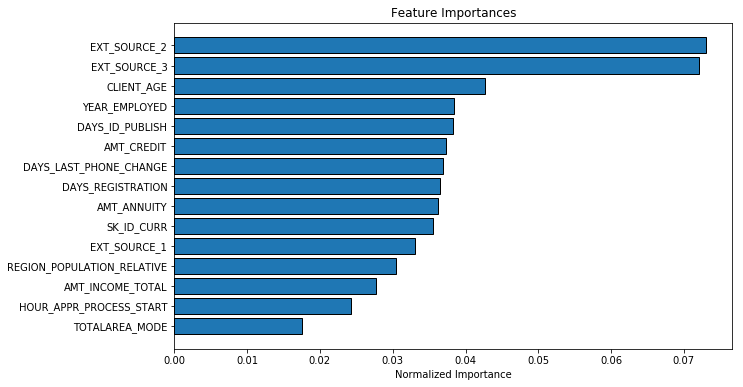

In [119]:
# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions. 

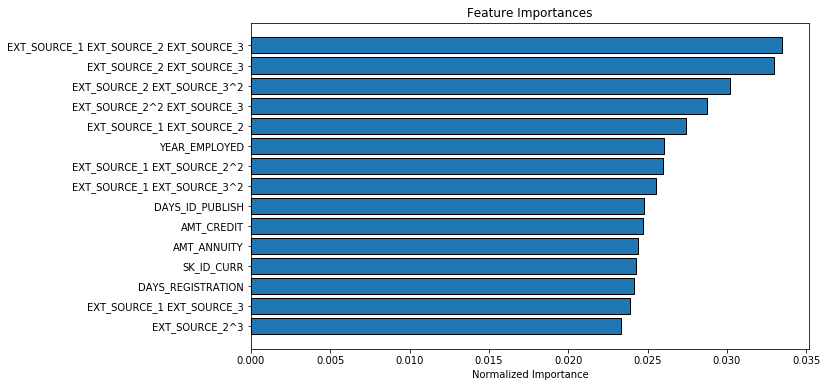

In [124]:
# Extract feature importances
feature_importance_values_poly = random_forest_poly.feature_importances_
feature_importances_poly = pd.DataFrame({'feature': poly_features_names, 'importance': feature_importance_values_poly})
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances_poly)

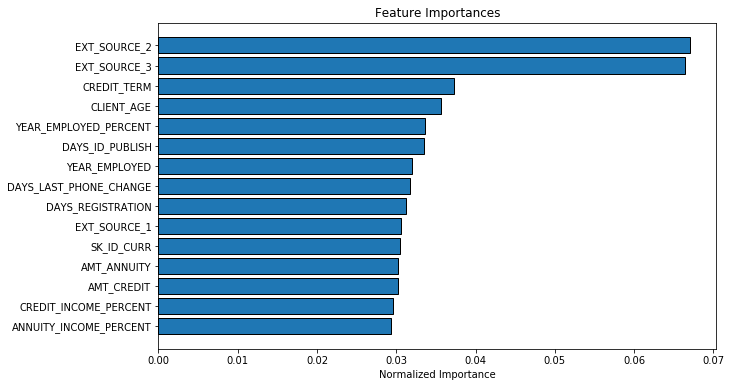

In [125]:
# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

Again, we see tha some of our features made it into the most important. Going forward, we will need to think about what other domain knowledge features may be useful for this problem (or we should consult someone who knows more about the financial industry! 

### LGB Interpretation: 

### Feature Importances

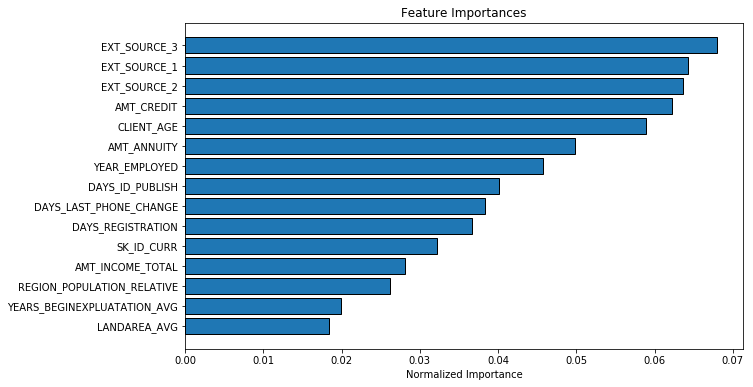

In [126]:
fi_sorted = plot_feature_importances(fi_base)

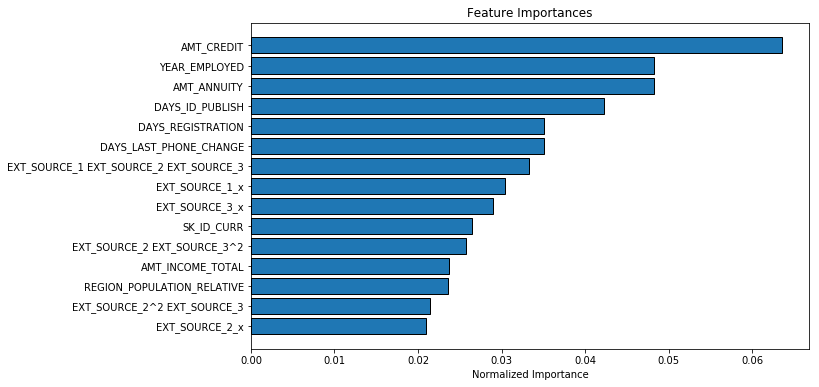

In [127]:
fi_sorted = plot_feature_importances(fi_poly)

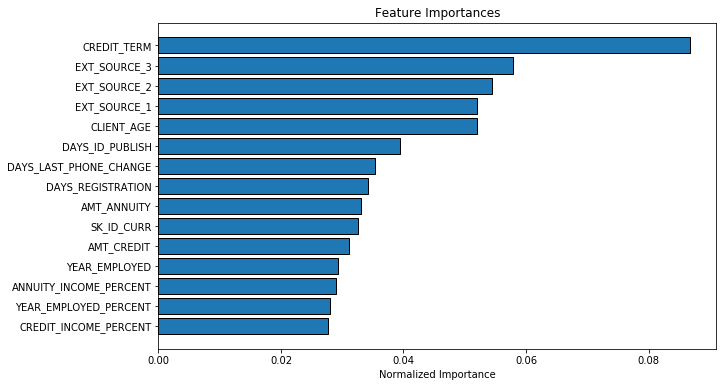

In [128]:
fi_sorted = plot_feature_importances(fi_domain)

## Using Dimensionality Reduction

In [129]:
from sklearn.decomposition import PCA

pca = PCA(n_components=22)
X_reduced = pd.DataFrame(pca.fit_transform(X),index=X.index)
X_reduced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-185938.000405,60016.747762,-178145.249122,-2731.239585,-1312.033178,-769.707976,-267.377710,-14.724783,2.565776,2.496883,0.654187,-0.738442,-1.935269,-0.225220,-0.152152,-0.278517,0.425085,1.038028,-1.144894,-0.140800,1.865393,1.658155
1,701788.131924,4909.601338,-178080.798825,10749.193035,-4088.306654,-2556.701999,5.254743,8.877649,3.712805,1.026923,-0.539666,-1.547215,-0.206315,-0.130061,-0.141329,-0.279568,-1.284276,0.250270,0.256923,0.135290,-0.710498,0.343702
2,-473905.998918,-36360.019669,-178273.852808,7202.550962,-957.878613,-438.075437,26.162033,9.606179,5.718336,2.391342,-1.604458,-1.883689,-0.875526,-0.059371,-0.210523,0.957867,-0.046487,-0.616299,-0.621099,0.232506,0.257577,-0.292150
3,-288066.280301,6074.837392,-178206.483921,-10450.196040,5004.199267,-793.343433,335.186728,5.671005,-1.517056,-5.066333,0.740754,-0.797132,0.106196,-0.245040,-0.200768,0.661491,0.427166,0.552405,0.272518,0.091583,0.187455,-0.467763
4,-91799.193727,-34848.964399,-178219.238844,2668.143879,-720.485984,501.815336,-139.778202,10.474925,-1.165725,0.566699,-1.573974,-1.843323,-1.052959,-0.218205,-0.236032,1.372287,0.118606,-0.618845,-0.060133,-0.171014,0.721234,-0.596146


### Random Forest With PCA


In [130]:
random_forest = RandomForestClassifier(n_estimators = 100, class_weight="balanced", random_state = 50, verbose = 1, n_jobs = -1)
kfold_model(random_forest,X_reduced,y,3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


********** 1 fold **********


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


train: 1.0 	 validate: 0.6318464886548323 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


********** 2 fold **********


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


train: 1.0 	 validate: 0.6405116955065981 **********


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


********** 3 fold **********


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s


train: 1.0 	 validate: 0.6334664554073188 **********
Mean train: 1.0 	 validate: 0.6352748798562498 **********


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


### LGB Forest With PCA


In [131]:
# try with Lgm
fi_reduce, metrics = model(X_reduced, y.TARGET,3)
print('Baseline metrics')
print(metrics)

Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.670527	train's auc: 0.751658
Early stopping, best iteration is:
[238]	valid's auc: 0.671397	train's auc: 0.76235
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.671802	train's auc: 0.750996
Early stopping, best iteration is:
[195]	valid's auc: 0.671975	train's auc: 0.749497
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.676899	train's auc: 0.749956
Early stopping, best iteration is:
[255]	valid's auc: 0.677553	train's auc: 0.766358
Baseline metrics
      fold     train     valid
0        0  0.762350  0.671397
1        1  0.749497  0.671975
2        2  0.766358  0.677553
3  overall  0.759402  0.673572


## Work On Imbalance Data (At Data Level.)

* Under sampling (decrease the `majority` class to be equal the `minority` one)
* Over sampling (increase the `minority` class to be equal the `majority` one)

## Under Sampling

In [132]:
X_train,X_test,y_train,y_test=train_test_split(X
                                               ,y.TARGET
                                               ,test_size=0.2
                                               , random_state=42
                                               , shuffle=True
                                               , stratify=y['TARGET']
                                              )

In [133]:
X_repay = X_train[y_train==1]
X_under_balance = X_repay.append(X_train[y_train==0].iloc[:len(X_repay)])
y_under_balance = y_train[X_under_balance.index]

In [134]:
y_under_balance.value_counts()

1    19860
0    19860
Name: TARGET, dtype: int64

## LGB With Under Sample

In [135]:
lgb_under_sample = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                           class_weight = 'balanced', learning_rate = 0.05, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 50)# evaluate the model
cv = StratifiedKFold(n_splits=5, random_state=1)
n_scores = cross_val_score(lgb_under_sample, X_under_balance, y_under_balance, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance
print(f'AUC: {np.mean(n_scores)}')

AUC: 0.7058249513969388


## Random Forest With Under Sample

In [136]:
RF_under_sample = RandomForestClassifier(n_estimators = 100, class_weight="balanced", random_state = 50, verbose = 1, n_jobs = -1)
# evaluate the model
cv = StratifiedKFold(n_splits=5, random_state=1)
n_scores = cross_val_score(RF_under_sample, X_under_balance, y_under_balance, scoring='roc_auc', cv=cv, n_jobs=-1)
# report performance
print(f'AUC: {np.mean(n_scores)}')

AUC: 0.7313569165933945


## HyberParameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

param_grid = {'learning_rate':[0.001,0.01,0.1]
             , 'max_depth':[3,5]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
model_lgb = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                           class_weight = 'balanced', learning_rate = 0.05, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1)

grid_clf = RandomizedSearchCV(model_lgb, param_grid, cv = cv, scoring= 'roc_auc')
grid_clf.fit(X_domain, y)
best = grid_clf.best_estimator_
print(grid_clf.best_estimator_)
print(np.abs(grid_clf.best_score_))

# Predict

In [ ]:
best.predict(app_test_domain)